In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 66.4MB/s 
     |████████████████████████████████| 460kB 53.5MB/s 
     |████████████████████████████████| 92kB 13.8MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
import konlpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [3]:
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

### 파일 업로드

In [5]:
from google.colab import files
uploaded, uploaded2 = files.upload(), files.upload()
filename = list(uploaded.keys())[0]
testfilename = list(uploaded2.keys())[0]

Saving ratings_train.txt to ratings_train (1).txt


Saving ratings_test.txt to ratings_test.txt


In [8]:
filename,testfilename

('ratings_train.txt', 'ratings_test.txt')

### 데이터 전처리

In [9]:
train_df= pd.read_table(filename)
test_df= pd.read_table(testfilename)
train_df.shape,test_df.shape

((53330, 3), (50000, 3))

In [10]:
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0.0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1.0
2,10265843,너무재밓었다그래서보는것을추천한다,0.0


In [11]:
test_df.head(3)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0


In [12]:
train_df.document.nunique()

52372

In [13]:
# 중복샘플 제거
train_df.drop_duplicates(subset=['document'],inplace=True)

In [14]:
train_df.document.isnull().sum()

1

In [15]:
# Null 값이 존재하는 행 제거
train_df=train_df.dropna(how='any') 

In [16]:
train_df['label'].value_counts()

0.0    26260
1.0    26111
Name: label, dtype: int64

테스트 데이터에도 적용

In [17]:
test_df.drop_duplicates(subset=['document'],inplace=True)
test_df=test_df.dropna(how='any') 

In [18]:
test_df.shape

(49157, 3)

### 한글 텍스트 전처리

In [19]:
train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_df.head(3)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0.0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1.0
2,10265843,너무재밓었다그래서보는것을추천한다,0.0


In [20]:
test_df['document'] = test_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_df.head(3)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0


In [21]:
train_df.document.replace('',np.nan,inplace=True)
train_df=train_df.dropna(how='any')

In [22]:
test_df.document.replace('',np.nan,inplace=True)
test_df=test_df.dropna(how='any')

In [23]:
train_df.shape,test_df.shape

((52204, 3), (48995, 3))

### 한글 토큰화와 불용어 추출

In [ ]:
import tqdm.notebook as tn
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

X_train=[]
for sentence in tn.tqdm(train_df['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [ ]:
X_test=[]
for sentence in tn.tqdm(test_df['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [ ]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [ ]:
# 정수 인코딩
max_words = 35000
tokenizer = Tokenizer(num_words=max_words) # 상위 35,000개의 단어만 보존
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train[:3]

[[50, 421, 16, 247, 709],
 [1015, 457, 41, 588, 1, 204, 1551, 25, 864, 742, 17],
 [371, 2483, 15303, 2645, 4553, 2, 221, 9]]

In [ ]:
# 전체 데이터의 길이 분포
print('리뷰의 최대 길이 :', max(len(s) for s in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 10.969829898092101


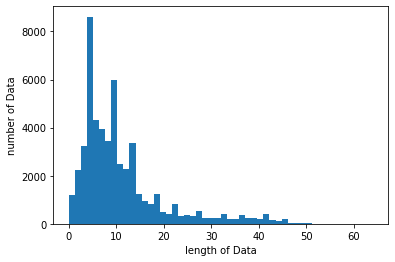

In [ ]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [ ]:
#  X_train과 X_test의 모든 샘플의 길이를 동일하게 30으로 셋팅
max_len=30
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
y_train = train_df.label.values
y_test = test_df.label.values

### LSTM 모델 정의/설정/학습/평가

In [ ]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential

In [ ]:
model = Sequential([
                    Embedding(max_words, 100),
                    LSTM(128),
                    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         3500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,617,377
Trainable params: 3,617,377
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
modelpath = "model/naver-lstm-best-model.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=4, batch_size=60,
                    validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/4
1944/1944 [==============================] - 74s 34ms/step - loss: 0.4372 - accuracy: 0.7909 - val_loss: 0.3509 - val_accuracy: 0.8459

Epoch 00001: val_loss improved from inf to 0.35091, saving model to model/naver-lstm-best-model.hdf5
Epoch 2/4
1944/1944 [==============================] - 63s 32ms/step - loss: 0.2837 - accuracy: 0.8806 - val_loss: 0.3427 - val_accuracy: 0.8524

Epoch 00002: val_loss improved from 0.35091 to 0.34272, saving model to model/naver-lstm-best-model.hdf5
Epoch 3/4
1944/1944 [==============================] - 62s 32ms/step - loss: 0.2250 - accuracy: 0.9085 - val_loss: 0.3822 - val_accuracy: 0.8486

Epoch 00003: val_loss did not improve from 0.34272
Epoch 4/4
1944/1944 [==============================] - 62s 32ms/step - loss: 0.1794 - accuracy: 0.9271 - val_loss: 0.4279 - val_accuracy: 0.8454

Epoch 00004: val_loss did not improve from 0.34272


In [ ]:
# Best Model 선택
from keras.models import load_model
del model
model = load_model(modelpath)

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test, 
                                           verbose=2)[1]))

1532/1532 - 4s - loss: 0.3499 - accuracy: 0.8474

 테스트 정확도: 0.8474


In [ ]:
# 테스트셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

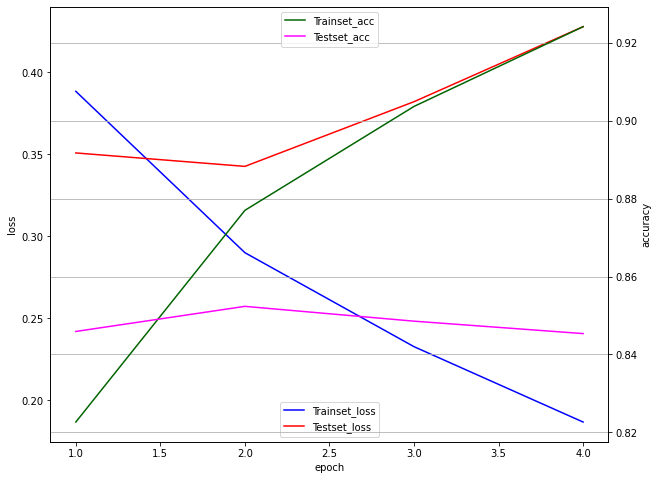

In [ ]:

x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='Trainset_loss')
ax0.plot(x_len, y_vloss, c="red", label='Testset_loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='Trainset_acc')
ax1.plot(x_len, y_vacc, c="magenta", label='Testset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()

### 심플 RNN으로 

In [ ]:
from keras.layers import Embedding, Dense, LSTM, SimpleRNN
model2 = Sequential([
                    Embedding(max_words, 100),
                    SimpleRNN(128),
                    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         3500000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               29312     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 3,529,441
Trainable params: 3,529,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
modelpath = "model/naver-simpleRnn-best-model.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [ ]:
history2 = model2.fit(X_train, y_train, epochs=4, batch_size=60,
                    validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/4
1944/1944 [==============================] - 96s 49ms/step - loss: 0.4715 - accuracy: 0.7609 - val_loss: 0.3726 - val_accuracy: 0.8364

Epoch 00001: val_loss improved from inf to 0.37257, saving model to model/naver-simpleRnn-best-model.hdf5
Epoch 2/4
1944/1944 [==============================] - 94s 48ms/step - loss: 0.3071 - accuracy: 0.8716 - val_loss: 0.3788 - val_accuracy: 0.8374

Epoch 00002: val_loss did not improve from 0.37257
Epoch 3/4
1944/1944 [==============================] - 93s 48ms/step - loss: 0.2271 - accuracy: 0.9091 - val_loss: 0.4339 - val_accuracy: 0.8181

Epoch 00003: val_loss did not improve from 0.37257
Epoch 4/4
1944/1944 [==============================] - 93s 48ms/step - loss: 0.1723 - accuracy: 0.9337 - val_loss: 0.5358 - val_accuracy: 0.8107

Epoch 00004: val_loss did not improve from 0.37257


In [ ]:
# Best Model 선택
from keras.models import load_model
del model
model2 = load_model(modelpath)

In [ ]:
print("\n 테스트 정확도: %.4f" % (model2.evaluate(X_test, y_test, 
                                           verbose=2)[1]))

1532/1532 - 5s - loss: 0.3758 - accuracy: 0.8336

 테스트 정확도: 0.8336


### 3. CNN + LSTM

In [ ]:
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D
model3 = Sequential([
                    Embedding(max_words, 120),
                    Dropout(0.5),
                    Conv1D(64, 5, padding='valid', activation='relu', strides=1),
                    MaxPooling1D(pool_size=4),
                    LSTM(60),
                    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 120)         4200000   
_________________________________________________________________
dropout (Dropout)            (None, None, 120)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 55)                26400     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 56        
Total params: 4,264,920
Trainable params: 4,264,920
Non-trainable params: 0
____________________________________________

In [ ]:
# 모델의 컴파일
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
modelpath = "model/naver-cnn-best-model.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [ ]:
history3 = model3.fit(X_train, y_train, epochs=4, batch_size=60,
                    validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/4
1944/1944 [==============================] - 79s 40ms/step - loss: 0.5349 - accuracy: 0.7059 - val_loss: 0.4472 - val_accuracy: 0.7765

Epoch 00001: val_loss improved from inf to 0.44721, saving model to model/naver-cnn-best-model.hdf5
Epoch 2/4
1944/1944 [==============================] - 76s 39ms/step - loss: 0.4005 - accuracy: 0.8080 - val_loss: 0.4431 - val_accuracy: 0.7819

Epoch 00002: val_loss improved from 0.44721 to 0.44310, saving model to model/naver-cnn-best-model.hdf5
Epoch 3/4
1944/1944 [==============================] - 75s 39ms/step - loss: 0.3488 - accuracy: 0.8335 - val_loss: 0.4597 - val_accuracy: 0.7785

Epoch 00003: val_loss did not improve from 0.44310
Epoch 4/4
1944/1944 [==============================] - 74s 38ms/step - loss: 0.3055 - accuracy: 0.8556 - val_loss: 0.5041 - val_accuracy: 0.7768

Epoch 00004: val_loss did not improve from 0.44310


In [ ]:
# Best Model 선택
from keras.models import load_model
del model
model3 = load_model(modelpath)

In [ ]:
print("\n 테스트 정확도: %.4f" % (model3.evaluate(X_test, y_test, 
                                           verbose=2)[1]))

1532/1532 - 3s - loss: 0.4515 - accuracy: 0.7755

 테스트 정확도: 0.7755
